In [70]:
#import bank marketing dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.decomposition import PCA
from scipy import stats

In [71]:
bank_full = pd.read_csv(r'C:\Users\wangs\Documents\SHAN WANG\SpringBoard-Datascience\Project\BANK MARKETING DATASET\bank-additional\bank-additional-full.csv', delimiter = ';')
print (bank_full.head())
print (bank_full.shape)

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

# Preprocess Data

In [4]:
#Divide dataset into trainX, trainY, testX, testY 
X = bank_full.drop(['y'], axis = 1).values
y = bank_full['y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
print (X_train[:10])
print (X_train.shape)

[[50 'blue-collar' 'married' 'basic.4y' 'unknown' 'unknown' 'unknown'
  'telephone' 'may' 'tue' 153 1 999 0 'nonexistent' 1.1 93.994 -36.4
  4.857 5191.0]
 [26 'blue-collar' 'single' 'high.school' 'no' 'no' 'no' 'telephone'
  'may' 'fri' 213 4 999 0 'nonexistent' 1.1 93.994 -36.4 4.855 5191.0]
 [34 'technician' 'married' 'high.school' 'no' 'yes' 'no' 'cellular'
  'aug' 'thu' 85 3 999 0 'nonexistent' 1.4 93.444 -36.1
  4.9639999999999995 5228.1]
 [30 'blue-collar' 'single' 'basic.9y' 'no' 'yes' 'no' 'telephone' 'may'
  'fri' 322 1 999 0 'nonexistent' 1.1 93.994 -36.4 4.855 5191.0]
 [29 'admin.' 'single' 'university.degree' 'no' 'yes' 'no' 'cellular'
  'nov' 'thu' 341 2 999 0 'nonexistent' -0.1 93.2 -42.0
  4.0760000000000005 5195.8]
 [34 'admin.' 'married' 'university.degree' 'no' 'no' 'yes' 'cellular'
  'may' 'mon' 73 2 999 0 'nonexistent' -1.8 92.89299999999999 -46.2 1.244
  5099.1]
 [29 'blue-collar' 'single' 'professional.course' 'no' 'no' 'no'
  'telephone' 'jun' 'fri' 86 2 999 0 '

In [6]:
#Identify numeric and categorical variables 
total_columns = bank_full.columns
print (total_columns)

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


In [7]:
num_columns = list(bank_full._get_numeric_data().columns)
print (num_columns)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [8]:
cat_columns = list(set(total_columns) - set(num_columns))
cat_columns.remove('y')
print (cat_columns)

['job', 'contact', 'marital', 'loan', 'default', 'housing', 'poutcome', 'day_of_week', 'education', 'month']


In [9]:
#apply one-hot encoding/dummy coding
#from sklearn.impute import SimpleImputer
#missing_values = ['unknown', 'nonexistent']
#my_imputer = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
#imputed_cat = my_imputer.fit(bank_full[cat_columns])
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
enc.fit(bank_full[cat_columns])
ohe = enc.transform(bank_full[cat_columns]).toarray()
print (ohe)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [10]:
#View the categories of each feature determined during fitting
print (enc.categories_)

[array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed', 'unknown'], dtype=object), array(['cellular', 'telephone'], dtype=object), array(['divorced', 'married', 'single', 'unknown'], dtype=object), array(['no', 'unknown', 'yes'], dtype=object), array(['no', 'unknown', 'yes'], dtype=object), array(['no', 'unknown', 'yes'], dtype=object), array(['failure', 'nonexistent', 'success'], dtype=object), array(['fri', 'mon', 'thu', 'tue', 'wed'], dtype=object), array(['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate',
       'professional.course', 'university.degree', 'unknown'],
      dtype=object), array(['apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct',
       'sep'], dtype=object)]


In [11]:
#Standardization,mean removal and variance scaling on the train set
X_train_df = pd.DataFrame(data = X_train, columns = bank_full.drop(['y'], axis = 1).columns)
X_train_df_num = X_train_df[num_columns]
X_train_scaled = preprocessing.scale(X_train_df_num)

In [12]:
X_train_scaled

array([[ 9.55475021e-01, -4.03103472e-01, -5.70952401e-01, ...,
         8.87038519e-01,  7.11732701e-01,  3.30697100e-01],
       [-1.34163595e+00, -1.71771054e-01,  5.20846948e-01, ...,
         8.87038519e-01,  7.10579541e-01,  3.30697100e-01],
       [-5.75932294e-01, -6.65280213e-01,  1.56913832e-01, ...,
         9.51836593e-01,  7.73426759e-01,  8.42703706e-01],
       ...,
       [-4.80219336e-01, -2.45026320e-01, -5.70952401e-01, ...,
         2.93897751e+00, -1.65397499e+00, -2.06372733e+00],
       [-1.65455049e-03,  1.44383251e-01, -2.07019285e-01, ...,
         8.87038519e-01,  7.11156121e-01,  3.30697100e-01],
       [-1.05449708e+00,  2.90893782e-01, -2.07019285e-01, ...,
        -4.73721023e-01,  7.71120439e-01,  8.42703706e-01]])

In [13]:
# Compute the mean and standard deviation on the testing set
scaler = preprocessing.StandardScaler().fit(X_train_df_num)
X_test_df = pd.DataFrame(data = X_test, columns = bank_full.drop(['y'], axis = 1).columns)
X_test_df_num = X_test_df[num_columns]
X_test_scaled = scaler.transform(X_test_df_num)

In [14]:
X_test_scaled

array([[ 1.62546572,  0.43740431, -0.5709524 , ..., -1.22969855,
        -1.3397389 , -0.93758881],
       [ 1.43403981,  0.10582785, -0.20701928, ...,  0.88703852,
         0.71346244,  0.3306971 ],
       [-0.67164525, -0.79251304, -0.5709524 , ..., -1.22969855,
        -1.33166678, -0.93758881],
       ...,
       [-0.09736751, -0.16020443, -0.5709524 , ...,  0.88703852,
         0.71288586,  0.3306971 ],
       [ 0.57262319, -0.62286927, -0.20701928, ..., -1.22969855,
        -1.3195586 , -0.93758881],
       [ 0.38119728, -0.549614  , -0.20701928, ...,  0.88703852,
         0.71057954,  0.3306971 ]])

# Exploratory Data Analysis

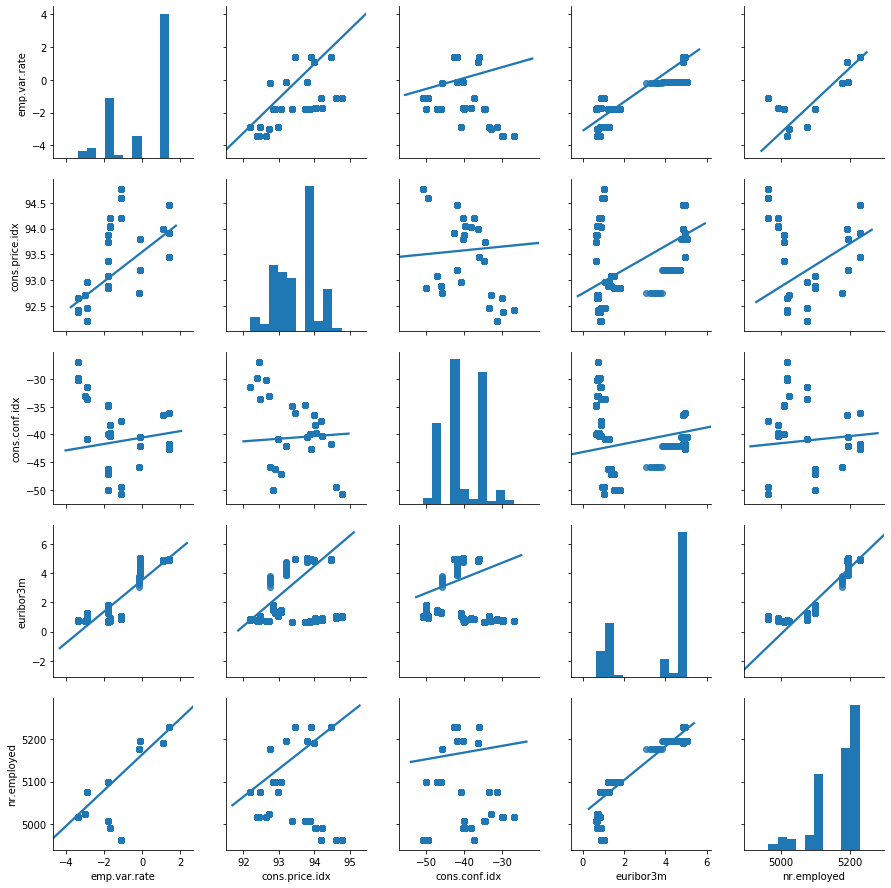

In [19]:
#plot
in_var = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
sns.pairplot(bank_full[in_var],kind='reg')
plt.show()

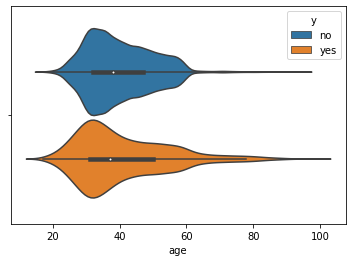

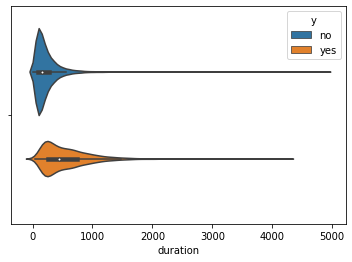

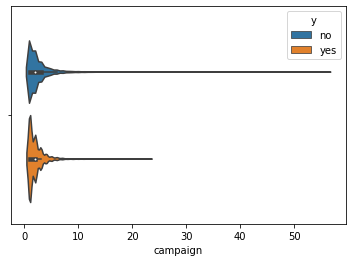

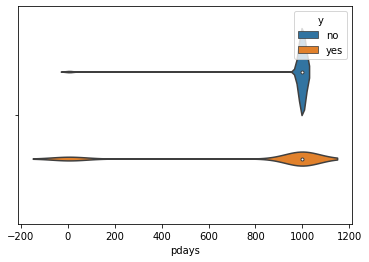

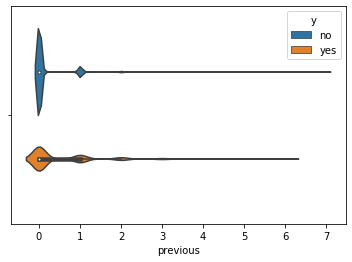

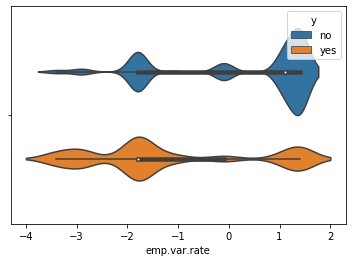

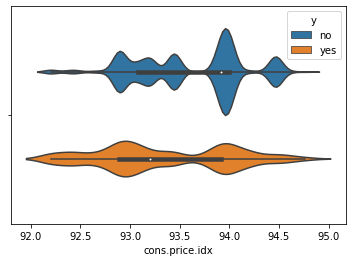

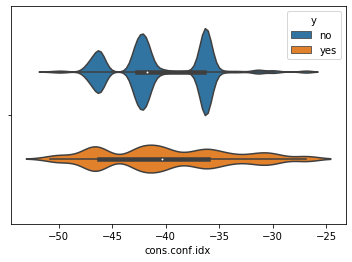

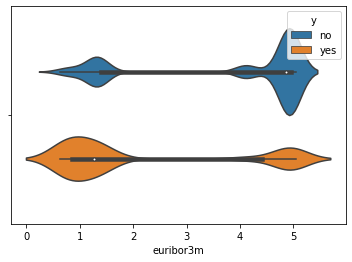

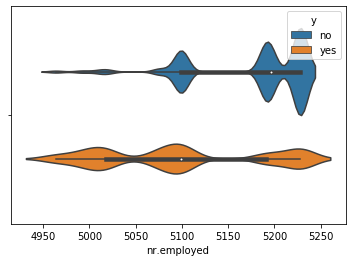

In [20]:
#Plot a box plot of numeric variable within subset of rows where label variable y ‘has the client subscribed a term deposit’ = ‘yes’ vs ‘no’
for var in num_columns:
    sns.violinplot( x=var, y=['']*len(bank_full), data = bank_full, hue ='y')
    plt.show()

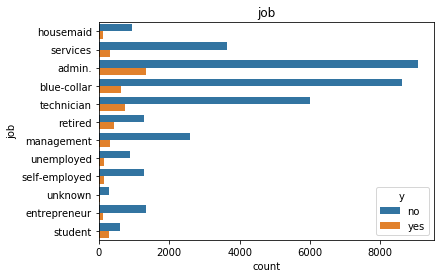

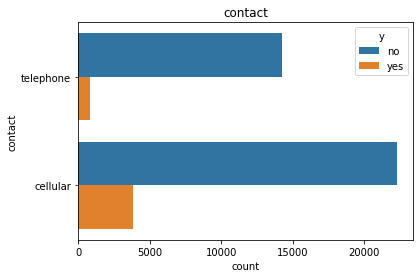

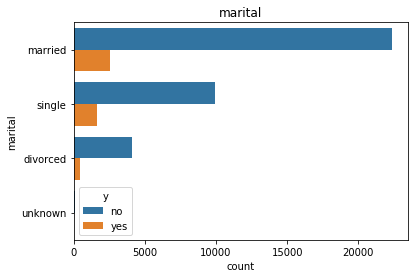

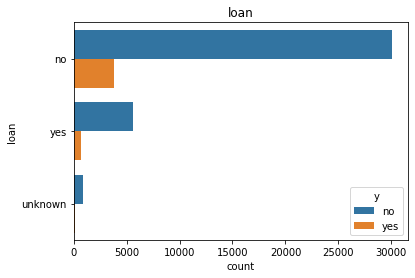

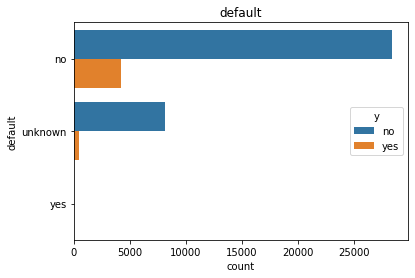

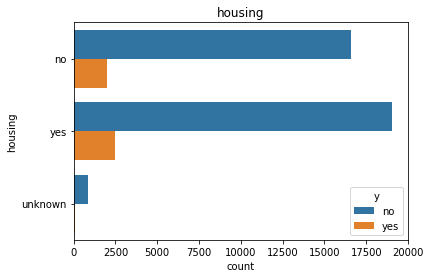

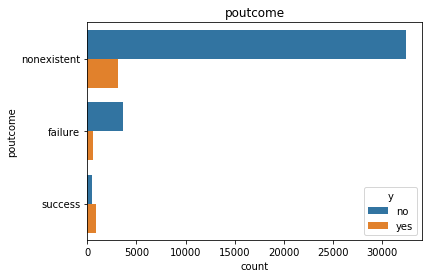

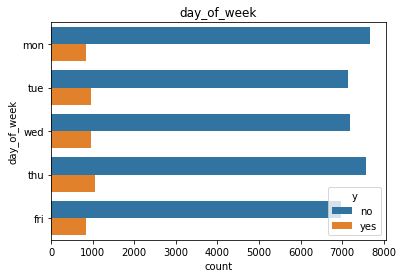

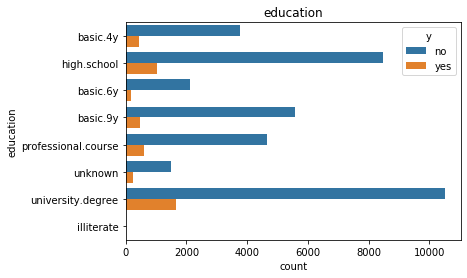

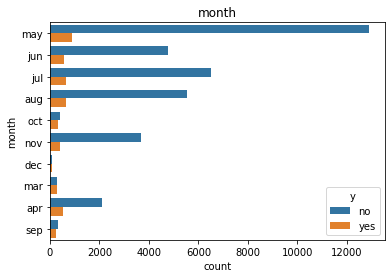

In [21]:
#Countplot for categorial variables
for var in cat_columns:
    sns.countplot(y=var,data = bank_full, hue ='y')
    plt.title(var)
    plt.show()

In [22]:
bank_full.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [98]:
job_education = pd.crosstab(bank_full['job'], bank_full['education']).apply(lambda r: r/r.sum(), axis = 1)
job_education

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
job,,,,,,,,
admin.,0.004031,0.012542,0.041657,0.324076,0.000000,0.035386,0.562262,0.020045
blue-collar,0.211652,0.139923,0.416400,0.115844,0.000674,0.060616,0.011618,0.043273
entrepreneur,0.078153,0.045293,0.146536,0.174956,0.001776,0.098579,0.424512,0.030195
housemaid,0.395028,0.063536,0.098066,0.172652,0.000000,0.067680,0.160221,0.042818
management,0.021613,0.022444,0.055278,0.090607,0.000000,0.029094,0.742727,0.038238
retired,0.335913,0.035604,0.071207,0.167183,0.001548,0.151703,0.181115,0.055728
self-employed,0.037838,0.010811,0.128829,0.081982,0.002703,0.116216,0.609910,0.011712
services,0.023553,0.049462,0.100606,0.682369,0.000000,0.056864,0.050135,0.037012
student,0.030708,0.017356,0.114820,0.423231,0.000000,0.053405,0.176235,0.184246


In [83]:
#Drop unknown values and make contigency tables for default vs outcome y, housing vs outcome y, and loan vs outcome y
bank_full = bank_full[~bank_full['default'].str.contains("unknown")]
bank_full = bank_full[~bank_full['housing'].str.contains("unknown")]
bank_full = bank_full[~bank_full['loan'].str.contains("unknown")]
dflt_y = pd.crosstab(bank_full['default'], bank_full['y'],  dropna = True)
house_y = pd.crosstab(bank_full['housing'], bank_full['y'])
loan_y = pd.crosstab(bank_full['loan'], bank_full['y'])
print (dflt_y, '\n\n', house_y, '\n\n', loan_y)

y           no   yes
default             
no       27724  4101
yes          3     0 

 y           no   yes
housing             
no       12797  1819
yes      14930  2282 

 y        no   yes
loan             
no    23374  3478
yes    4353   623


In [84]:
# Run fisher’s exact test between default vs outcome y,  housing vs outcome y, and loan vs outcome y
con_tables = [dflt_y,house_y,loan_y]
names= [('dflt_oddsratio', 'dflt_pvalue'), ('house_oddsratio','house_pvalue'), ('loan_oddsratio', 'loan_oddsratio')]
i=0
for t in con_tables:
    oddsratio, pvalue = stats.fisher_exact(t)
    print (names[i][0],':', oddsratio, names[i][1],':', pvalue)
    i+=1

dflt_oddsratio : 0.0 dflt_pvalue : 1.0
house_oddsratio : 1.0753041037762077 house_pvalue : 0.03165671858028662
loan_oddsratio : 0.9618400164758509 loan_oddsratio : 0.4201256664896338


In [85]:
#Apply principal components analysis to numerical variables
pca = PCA(n_components = 2)
pca.fit(bank_full[num_columns])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.5906462  0.36661537]
[46733.72598352 36819.00382113]


In [86]:
pca = PCA(n_components=0.8)
n_pca = pca.fit_transform(bank_full[num_columns])
print (bank_full[num_columns].shape, n_pca.shape)

(31828, 10) (31828, 2)


In [87]:
#Apply principal components analysis to one hot encoded data 
pca = PCA(n_components = 2)
pca.fit(ohe)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.11256323 0.08483206]
[161.78192211 140.44675747]


In [89]:
pca = PCA(n_components=0.8)
c_pca = pca.fit_transform(ohe)
print (ohe.shape, c_pca.shape)

(41188, 53) (41188, 17)
